<a href="https://colab.research.google.com/github/yingzibu/a_inhibitor_design/blob/main/examples/selfies_dataset_chemVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -R 'a_inhibitor_design'
! git clone https://github.com/yingzibu/a_inhibitor_design.git --quiet
!rm -R 'JAK_ML'
! git clone https://github.com/yingzibu/JAK_ML.git --quiet
!rm -R 'JAK-MTATFP'
! git clone https://github.com/Yimeng-Wang/JAK-MTATFP.git --quiet

rm: cannot remove 'a_inhibitor_design': No such file or directory
rm: cannot remove 'JAK_ML': No such file or directory
rm: cannot remove 'JAK-MTATFP': No such file or directory


In [2]:
! pip install pubchempy --quiet
! pip install rdkit --quiet
! pip install selfies --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 16.0 MB/s eta 0:00:00


In [ ]:
data_path_CoGT = '/content/JAK_ML/new_data/'

from os import walk
import pandas as pd
files = next(walk(data_path_CoGT), [None, None, []])[2]
all_smiles_list = []
for f in files:
    data_name = data_path_CoGT + f
    data = pd.read_csv(data_name)
    all_smiles_list.extend(data['Smiles'].values.tolist())
    print(len(all_smiles_list))

In [ ]:
data_path_MTATFP = '/content/JAK-MTATFP/Data/'
files = next(walk(data_path_MTATFP), [None, None, []])[2]

for f in files:
    data_name = data_path_MTATFP + f
    if data_name.split('.')[-1] == 'csv':
        data = pd.read_csv(data_name)
        assert 'SMILES' in data.columns
        all_smiles_list.extend(data['SMILES'].values.tolist())
        print(len(all_smiles_list))

smiles_no_repeat = [*set(all_smiles_list)]

In [13]:
print('all smiles no duplicates: ', len(smiles_no_repeat))

all smiles no duplicates:  21219


In [ ]:
cd a_inhibitor_design/data/

In [30]:
from tokenizer_selfies import SmilesToSelfies, SelfiesToDataset

selfies_df = SmilesToSelfies(smiles_no_repeat)
print(selfies_df.head())
print(selfies_df.shape)

100%|██████████| 21219/21219 [00:24<00:00, 879.37it/s]

                                             Selfies
0  [C][N][Branch1][=C][C][=N][C][=N][C][NH1][C][=...
1  [C][N][Branch1][N][C][=C][N][=C][Branch1][C][B...
2  [C][N][Branch1][=C][C][=N][C][=N][C][NH1][C][=...
3  [C][N][C][/C][=C][/C][C][O][C][=C][C][=C][C][=...
4  [N][#C][C@@H1][C][C][C][C][C@H1][Ring1][=Branc...
(21219, 1)


In [31]:
MAX_LEN = 120
print('define the max len of dataset')
dict_ = SelfiesToDataset(selfies_df, max_len=MAX_LEN, savename='test.pt')
a = selfies_df['Selfies'].tolist()

define the max len of dataset
len alphabet:  66
max len in dataset: 387
current defined max len:  120 < 387, Abort


In [38]:
import selfies as sf
alphabet = sf.get_alphabet_from_selfies(a)
alphabet.add("[nop]")
alphabet.add('.')
len(alphabet)
alphabet = list(sorted(alphabet))
print('len alphabet: ', len(alphabet))

len alphabet:  66


In [39]:
lens = [sf.len_selfies(s) for s in a]

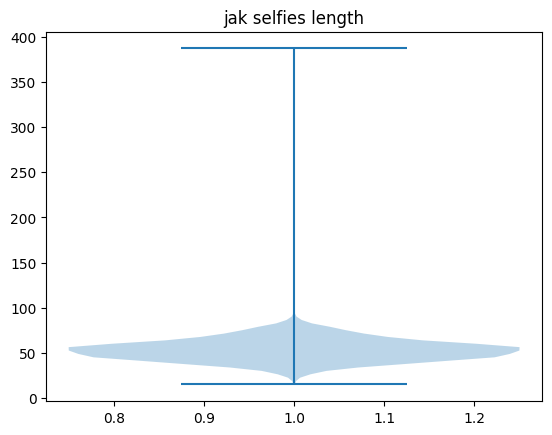

previous chembl total compound:  21219
mean +/- std tokens : 53.276 +/- 12.673


In [40]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(10)

fig = plt.figure()

bp = plt.violinplot(lens)
plt.title('jak selfies length')
plt.show()

print('previous chembl total compound: ', len(lens))
print(f'mean +/- std tokens : {np.mean(lens):.3f} +/- {np.std(lens):.3f}')

In [54]:
len(lens)

21219

In [42]:
import torch
from tqdm import tqdm
import os

def SelfiesToDataset(selfies_df, max_len, savename=None, delete_long=True):
    """
    Convert selfies into dataset. Dictionary
    dict_ = {'labels': labels,
         'one_hots': one_hots,
         'alphabet': alphabet}
    :param selfies_df: dataframe of selfies
    :param savename: save file name
    :param delete_long:
        True: delete long selfies if exceend max_len
        False: will truncate selfies to max_len

    Return a dictionary containing
        labels (len_dataset, max_len)
        onehots (len_dataset, max_len, len_alphabet)
        alphabet: a list of tokens
    """
    dataset = []
    if isinstance(selfies_df, pd.DataFrame):
        dataset = selfies_df['Selfies'].tolist()
    else: dataset = selfies_df # dataset type: list


    alphabet = sf.get_alphabet_from_selfies(dataset)
    alphabet.add("[nop]")
    alphabet.add('.')
    alphabet = list(sorted(alphabet))
    print('len alphabet: ', len(alphabet))
    __t2i_sf = {s: i for i, s in enumerate(alphabet)}

    max_len_in_dataset = max(sf.len_selfies(s) for s in dataset)
    print('max len in dataset:', max_len_in_dataset)
    if max_len < max_len_in_dataset:
        print(f'current defined max len: ',
              f'{max_len} < {max_len_in_dataset}')
        if delete_long:
            print('delete long selfies')

    labels = []
    one_hots = []
    for selfi in tqdm(dataset, total=len(dataset)):
        if sf.len_selfies(selfi) > max_len and delete_long:
            pass
        else:
            label, one_hot = sf.selfies_to_encoding(
                selfies = selfi, vocab_stoi = __t2i_sf,
                pad_to_len = max_len, enc_type='both')
            labels.append(label)
            one_hots.append(one_hot)

    labels = torch.Tensor(labels).long()
    one_hots = torch.Tensor(one_hots).long()
    dict_ = {'labels': labels,
            'one_hots': one_hots,
            'alphabet': alphabet}
    if savename != None and savename.split('.')[-1] == 'pt':
        torch.save(dict_, savename)
        print('dataset saved at:', os.getcwd() + '/' + savename)
    return dict_


In [43]:
dict_ = SelfiesToDataset(selfies_df, max_len=120, savename='test.pt')

len alphabet:  66
max len in dataset: 387
current defined max len:  120 < 387
delete long selfies


100%|██████████| 21219/21219 [00:09<00:00, 2170.24it/s]


dataset saved at: test.pt


In [57]:
model = MolecularVAE()

/content/a_inhibitor_design


In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


class MolecularVAE(nn.Module):
    def __init__(self, in_dim, z_dim=292):
        """
        param: in_dim = [batch_size, max_len, len(alphabet)]
        param: z_dim: z dimension
        """

        super(MolecularVAE, self).__init__()

        (_, max_len, alphabet_len) = in_dim
        # self.in_dim = in_dim
        self.max_len = max_len
        self.alphabet_len = alphabet_len
        self.kld = 0

        self.conv_1 = nn.Conv1d(max_len, 9, kernel_size = 9) #[bs, 9, nchar-8]
        self.conv_2 = nn.Conv1d(9, 9, kernel_size=9) # [bs, 9, nchar-16] -8
        self.conv_3 = nn.Conv1d(9, 10, kernel_size=11) # [bs, 10, nchar-26] -10
        self.linear_0 = nn.Linear(10*(alphabet_len - 26), 435)
        self.mu = nn.Linear(435, z_dim)
        self.logvar = nn.Linear(435, z_dim)

        self.linear_3 = nn.Linear(z_dim, z_dim)
        self.gru = nn.GRU(z_dim, 501, 3, batch_first=True)
        self.linear_4 = nn.Linear(501, alphabet_len)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()


    def encode(self, x):

        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.relu(self.conv_3(x))
        x = x.view(x.size(0), -1) # (batch_size, size(-2) * size(-1))
        # print('after view', x.shape)
        x = F.selu(self.linear_0(x))

        mu = self.mu(x)
        logvar = F.softplus(self.logvar(x))
        return mu, logvar

    def reparametrize(self, mu, logvar):
        epsilon = Variable(torch.rand(mu.size()), requires_grad=False)
        if mu.is_cuda: epsilon = epsilon.cuda()
        std = logvar.mul(0.5).exp_()
        z = mu.addcmul(std, epsilon)
        return z

    def decode(self, z):
        z = F.selu(self.linear_3(z))
        z = z.view(z.size(0), 1, z.size(-1)).repeat(1, self.max_len, 1)
        output, hn = self.gru(z)
        out_reshape = output.contiguous().view(-1, output.size(-1))
        y0 = F.softmax(self.linear_4(out_reshape), dim=1)
        y = y0.contiguous().view(output.size(0), -1, y0.size(-1))
        return y

    def update_kld(self, mu, logvar):
        self.kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    def get_kld(self):
        return self.kld

    def forward(self, x):
        mu, logvar = self.encode(x)
        self.update_kld(mu, logvar)
        z = self.reparametrize(mu, logvar)
        return self.decode(z)


In [ ]:
print(a.keys())


In [120]:
import os
def plot_kld(train_dict, test_dict):
    fig = plt.figure()
    plt.plot(list(train_dict.keys()), list(train_dict.values()), label='train')
    plt.plot(list(test_dict.keys()), list(test_dict.values()), label='test')
    plt.xlabel('epoch')
    plt.ylabel('KLD percent')
    plt.title('KLD percentage in total loss')
    plt.legend()
    plt.show()

dict_keys(['labels', 'one_hots', 'alphabet'])

In [68]:
a['labels'].shape, a['one_hots'].shape, len(a['alphabet'])

(torch.Size([21208, 120]), torch.Size([21208, 120, 66]), 66)

In [65]:
total = a['one_hots'].shape[0]

data_train = a['one_hots'][:int(total*0.8)]
data_valid = a['one_hots'][int(total*0.8):int(total*0.9)]
data_test = a['one_hots'][int(total*0.9):]
print(data_train.shape, data_valid.shape, data_test.shape)

torch.Size([16966, 120, 66]) torch.Size([2121, 120, 66]) torch.Size([2121, 120, 66])


In [116]:
from torch.utils.data import DataLoader
batch_size = 64
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)

In [73]:
from model.evaluate_utils import get_min, plot_loss
os.mkdir('model_files/')

In [118]:
import torch.optim as optim
assert MAX_LEN == data_train.shape[1]
assert len(a['alphabet']) == data_train.shape[2]

in_dim = [batch_size, data_train.shape[1], data_train.shape[2]]

cuda = torch.cuda.is_available()
if cuda: device = 'cuda'
else: device = 'cpu'

model = MolecularVAE(in_dim).to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))
optimizer = optim.AdamW(params=model.parameters(), lr=1e-3, weight_decay=1e-2)


In [121]:
def train(epoch, beta_kl=None): # beta_kl = BCE/KLD ok?
    model.train()
    train_loss = 0
    BCE_loss = 0
    KLD_loss = 0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader),
                        desc=f'epoch {epoch}'):
        data = data.to(device).type(torch.float32)

        optimizer.zero_grad()
        output = model(data)

        BCE = F.binary_cross_entropy(output, data, reduction='sum')
        KLD = model.get_kld()
        if beta_kl != None:
            beta = beta_kl[i*epoch]
            loss = BCE + beta * KLD
        else: loss = BCE + KLD
        loss.backward()
        optimizer.step()

        train_loss += loss.data.item()
        BCE_loss += BCE.data.item()
        KLD_loss += KLD.data.item()

    train_loss /= len(train_loader)
    BCE_loss /= len(train_loader)
    KLD_loss /= len(train_loader)
    KLD_percent = KLD_loss/train_loss
    print(f'[train] loss: {train_loss:.3f}, BCE: {BCE_loss:.3f}, '
          f'KLD: {KLD_loss:.3f}, KLD/loss: {KLD_percent*100:.3f}%')
    return train_loss, BCE_loss, KLD_loss, KLD_percent

def test(epoch, test_loader=test_loader):
    model.eval()
    test_loss = 0
    BCE_loss = 0
    KLD_loss = 0
    for data in test_loader:
        data = data.to(device).type(torch.float32)
        output = model(data)
        BCE = F.binary_cross_entropy(output, data,
                                      reduction='sum').data.item()
        KLD = model.get_kld().data.item()

        test_loss += BCE + KLD
        BCE_loss += BCE
        KLD_loss += KLD
    test_loss /= len(test_loader)
    BCE_loss /= len(test_loader)
    KLD_loss /= len(test_loader)
    KLD_percent = KLD_loss / test_loss
    print(f'[valid] loss: {test_loss:.3f}, BCE: {BCE_loss:.3f}, '
          f'KLD: {KLD_loss:.3f}, KLD/loss: {KLD_percent*100:.3f}%')
    return test_loss, BCE_loss, KLD_loss, KLD_percent

train_dict, valid_dict = {}, {}
train_kld, valid_kld = {}, {}
epochs = 1000
model_path = 'model_files/'
model_saved_names = []
argmin_epoch = -1

295

epoch 343: 100%|██████████| 266/266 [00:25<00:00, 10.24it/s]


[train] loss: 8450.728, BCE: 8068.122, KLD: 382.606, KLD/loss: 4.527%
[valid] loss: 8612.080, BCE: 8242.307, KLD: 369.774, KLD/loss: 4.294%


epoch 344: 100%|██████████| 266/266 [00:26<00:00,  9.97it/s]


[train] loss: 8455.811, BCE: 8073.110, KLD: 382.701, KLD/loss: 4.526%
[valid] loss: 8617.454, BCE: 8247.408, KLD: 370.046, KLD/loss: 4.294%


epoch 345: 100%|██████████| 266/266 [00:26<00:00, 10.16it/s]


[train] loss: 8455.088, BCE: 8072.362, KLD: 382.727, KLD/loss: 4.527%
[valid] loss: 8600.816, BCE: 8230.801, KLD: 370.015, KLD/loss: 4.302%


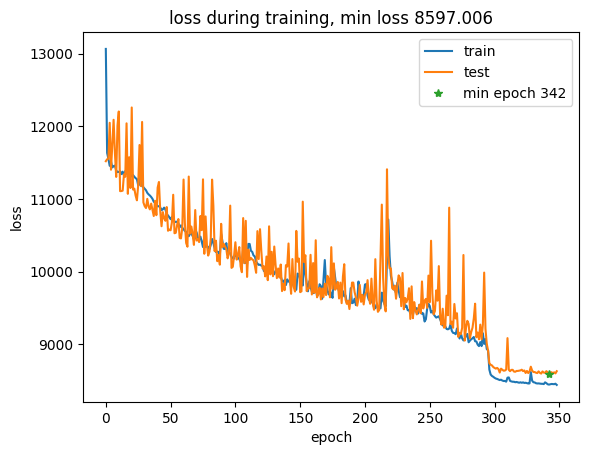

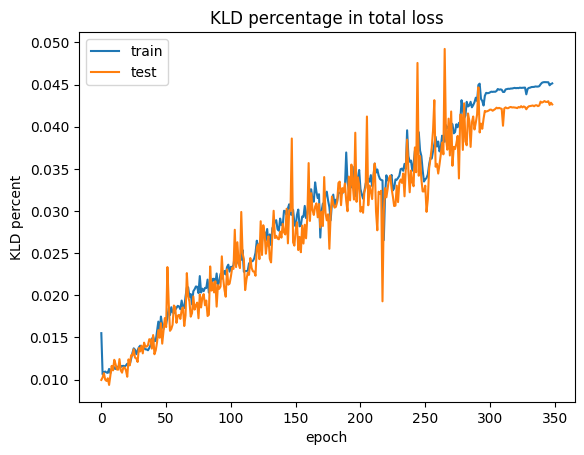

epoch 346: 100%|██████████| 266/266 [00:26<00:00, 10.18it/s]


[train] loss: 8448.539, BCE: 8065.844, KLD: 382.695, KLD/loss: 4.530%
[valid] loss: 8610.287, BCE: 8240.278, KLD: 370.010, KLD/loss: 4.297%


epoch 347: 100%|██████████| 266/266 [00:26<00:00, 10.15it/s]


[train] loss: 8449.692, BCE: 8067.001, KLD: 382.691, KLD/loss: 4.529%
[valid] loss: 8605.541, BCE: 8235.539, KLD: 370.002, KLD/loss: 4.300%


epoch 348: 100%|██████████| 266/266 [00:26<00:00, 10.14it/s]


[train] loss: 8448.244, BCE: 8065.567, KLD: 382.677, KLD/loss: 4.530%
[valid] loss: 8619.129, BCE: 8249.158, KLD: 369.971, KLD/loss: 4.292%


epoch 349: 100%|██████████| 266/266 [00:26<00:00, 10.17it/s]


[train] loss: 8450.305, BCE: 8067.644, KLD: 382.662, KLD/loss: 4.528%
[valid] loss: 8603.482, BCE: 8233.503, KLD: 369.979, KLD/loss: 4.300%


epoch 350: 100%|██████████| 266/266 [00:26<00:00, 10.21it/s]


[train] loss: 8453.085, BCE: 8070.423, KLD: 382.662, KLD/loss: 4.527%
[valid] loss: 8613.570, BCE: 8243.609, KLD: 369.961, KLD/loss: 4.295%


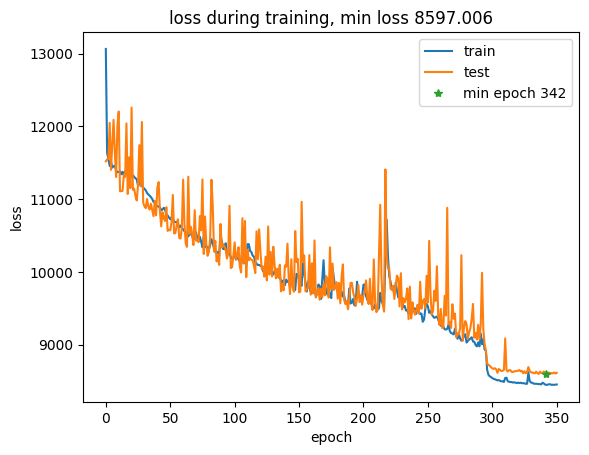

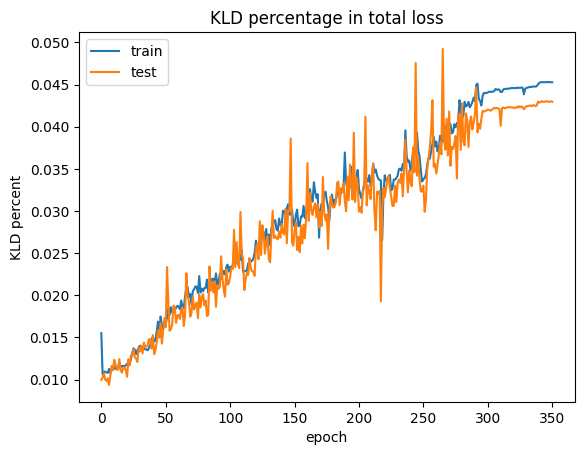

epoch 351: 100%|██████████| 266/266 [00:26<00:00, 10.05it/s]


[train] loss: 8455.523, BCE: 8072.881, KLD: 382.642, KLD/loss: 4.525%
[valid] loss: 8616.138, BCE: 8246.185, KLD: 369.953, KLD/loss: 4.294%


epoch 352: 100%|██████████| 266/266 [00:26<00:00, 10.17it/s]


[train] loss: 8448.740, BCE: 8066.106, KLD: 382.634, KLD/loss: 4.529%
[valid] loss: 8639.522, BCE: 8269.591, KLD: 369.931, KLD/loss: 4.282%


epoch 353: 100%|██████████| 266/266 [00:26<00:00, 10.18it/s]


[train] loss: 8450.198, BCE: 8067.591, KLD: 382.606, KLD/loss: 4.528%
[valid] loss: 8584.508, BCE: 8214.612, KLD: 369.896, KLD/loss: 4.309%
model save at:  model_files/ckpt_353.pt
remove  model_files/ckpt_299.pt


epoch 354: 100%|██████████| 266/266 [00:26<00:00, 10.15it/s]


[train] loss: 8454.860, BCE: 8072.281, KLD: 382.579, KLD/loss: 4.525%
[valid] loss: 8590.153, BCE: 8220.288, KLD: 369.865, KLD/loss: 4.306%


epoch 355: 100%|██████████| 266/266 [00:26<00:00, 10.13it/s]


[train] loss: 8449.642, BCE: 8067.080, KLD: 382.562, KLD/loss: 4.528%
[valid] loss: 8595.563, BCE: 8225.704, KLD: 369.859, KLD/loss: 4.303%


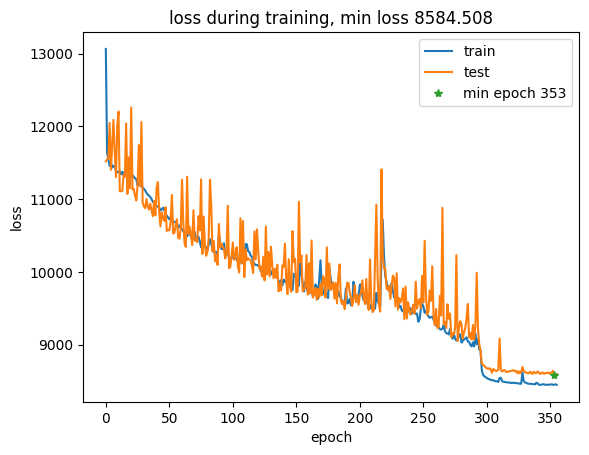

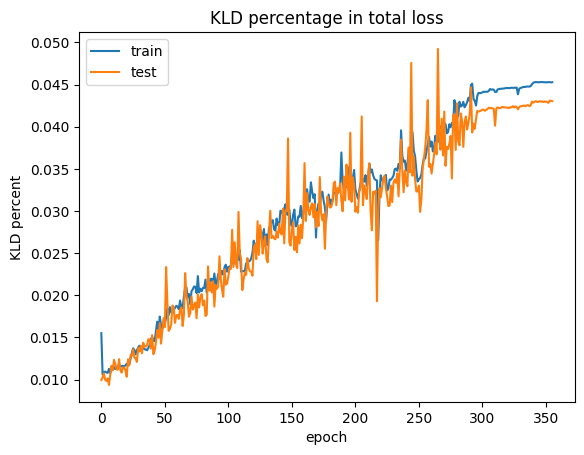

epoch 356: 100%|██████████| 266/266 [00:26<00:00, 10.17it/s]


[train] loss: 8454.717, BCE: 8072.164, KLD: 382.553, KLD/loss: 4.525%
[valid] loss: 8612.331, BCE: 8242.484, KLD: 369.847, KLD/loss: 4.294%


epoch 357: 100%|██████████| 266/266 [00:26<00:00, 10.20it/s]


[train] loss: 8448.168, BCE: 8065.638, KLD: 382.529, KLD/loss: 4.528%
[valid] loss: 8626.861, BCE: 8257.045, KLD: 369.816, KLD/loss: 4.287%


epoch 358: 100%|██████████| 266/266 [00:26<00:00, 10.18it/s]


[train] loss: 8443.829, BCE: 8061.338, KLD: 382.491, KLD/loss: 4.530%
[valid] loss: 8611.742, BCE: 8241.966, KLD: 369.776, KLD/loss: 4.294%


epoch 359: 100%|██████████| 266/266 [00:26<00:00, 10.17it/s]


[train] loss: 8444.411, BCE: 8061.959, KLD: 382.452, KLD/loss: 4.529%
[valid] loss: 8598.126, BCE: 8228.391, KLD: 369.735, KLD/loss: 4.300%


epoch 360: 100%|██████████| 266/266 [00:26<00:00, 10.14it/s]


[train] loss: 8455.919, BCE: 8073.486, KLD: 382.432, KLD/loss: 4.523%
[valid] loss: 8615.343, BCE: 8245.602, KLD: 369.740, KLD/loss: 4.292%


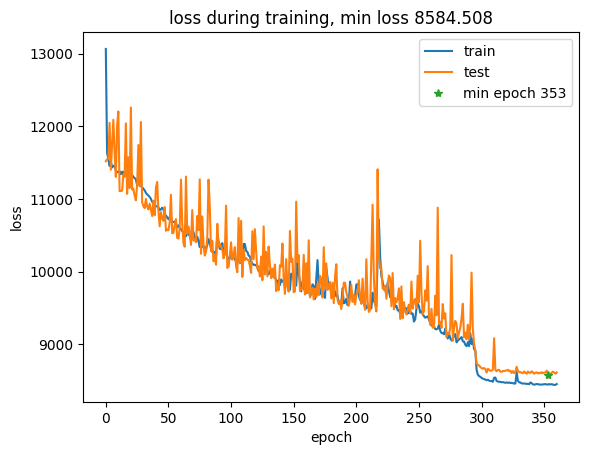

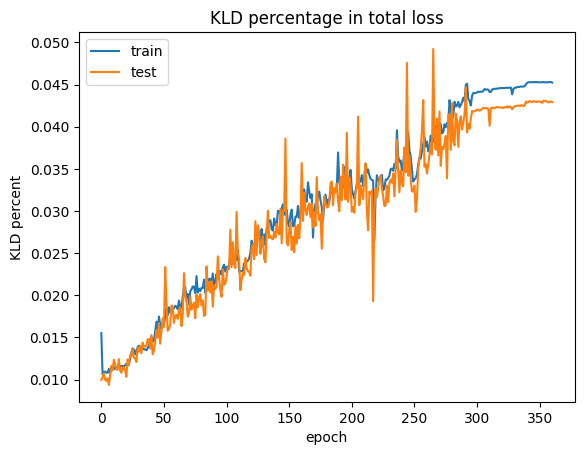

epoch 361: 100%|██████████| 266/266 [00:26<00:00, 10.18it/s]


[train] loss: 8443.711, BCE: 8061.263, KLD: 382.448, KLD/loss: 4.529%
[valid] loss: 8629.222, BCE: 8259.484, KLD: 369.738, KLD/loss: 4.285%


epoch 362: 100%|██████████| 266/266 [00:26<00:00, 10.16it/s]


[train] loss: 8456.592, BCE: 8074.151, KLD: 382.441, KLD/loss: 4.522%
[valid] loss: 8634.049, BCE: 8264.285, KLD: 369.764, KLD/loss: 4.283%


epoch 363: 100%|██████████| 266/266 [00:26<00:00, 10.11it/s]


[train] loss: 8444.219, BCE: 8061.772, KLD: 382.448, KLD/loss: 4.529%
[valid] loss: 8604.263, BCE: 8234.543, KLD: 369.721, KLD/loss: 4.297%


epoch 364: 100%|██████████| 266/266 [00:26<00:00, 10.22it/s]


[train] loss: 8453.644, BCE: 8071.215, KLD: 382.429, KLD/loss: 4.524%
[valid] loss: 8601.468, BCE: 8231.749, KLD: 369.719, KLD/loss: 4.298%


epoch 365: 100%|██████████| 266/266 [00:26<00:00, 10.19it/s]


[train] loss: 8445.754, BCE: 8063.372, KLD: 382.382, KLD/loss: 4.528%
[valid] loss: 8593.911, BCE: 8224.230, KLD: 369.681, KLD/loss: 4.302%


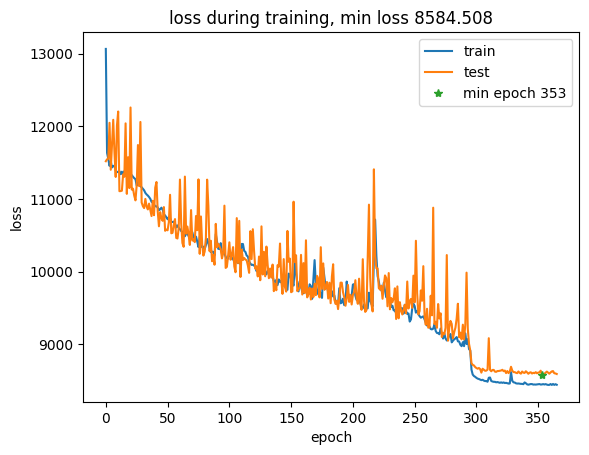

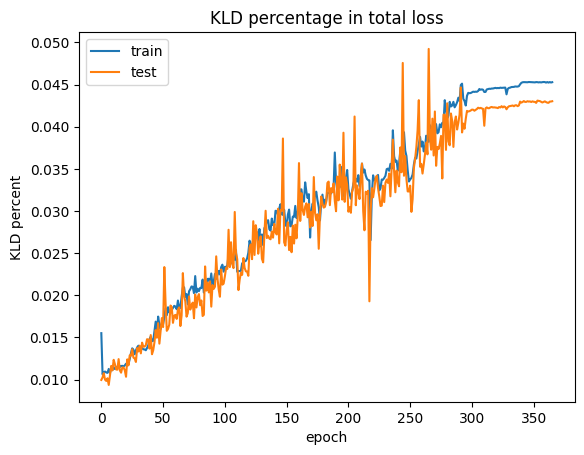

epoch 366: 100%|██████████| 266/266 [00:26<00:00, 10.16it/s]


[train] loss: 8444.149, BCE: 8061.760, KLD: 382.389, KLD/loss: 4.528%
[valid] loss: 8606.671, BCE: 8236.981, KLD: 369.690, KLD/loss: 4.295%


epoch 367: 100%|██████████| 266/266 [00:26<00:00, 10.13it/s]


[train] loss: 8449.334, BCE: 8066.956, KLD: 382.378, KLD/loss: 4.526%
[valid] loss: 8607.456, BCE: 8237.802, KLD: 369.654, KLD/loss: 4.295%


epoch 368: 100%|██████████| 266/266 [00:26<00:00, 10.13it/s]


[train] loss: 8445.847, BCE: 8063.473, KLD: 382.374, KLD/loss: 4.527%
[valid] loss: 8595.070, BCE: 8225.412, KLD: 369.658, KLD/loss: 4.301%


epoch 369: 100%|██████████| 266/266 [00:26<00:00, 10.15it/s]


[train] loss: 8450.044, BCE: 8067.680, KLD: 382.364, KLD/loss: 4.525%
[valid] loss: 8611.910, BCE: 8242.051, KLD: 369.859, KLD/loss: 4.295%


epoch 370: 100%|██████████| 266/266 [00:26<00:00, 10.11it/s]


[train] loss: 8454.160, BCE: 8071.402, KLD: 382.758, KLD/loss: 4.527%
[valid] loss: 8602.899, BCE: 8232.847, KLD: 370.052, KLD/loss: 4.301%


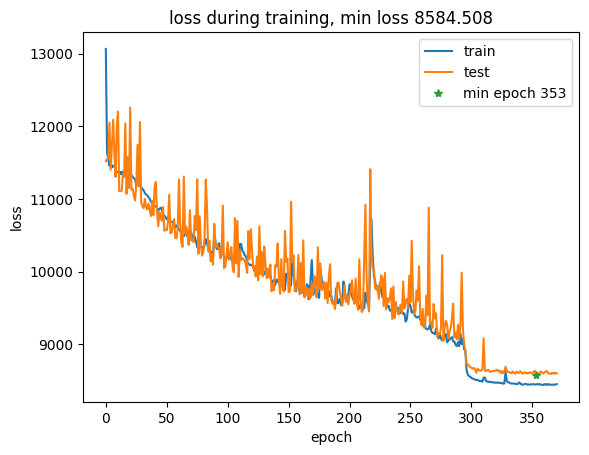

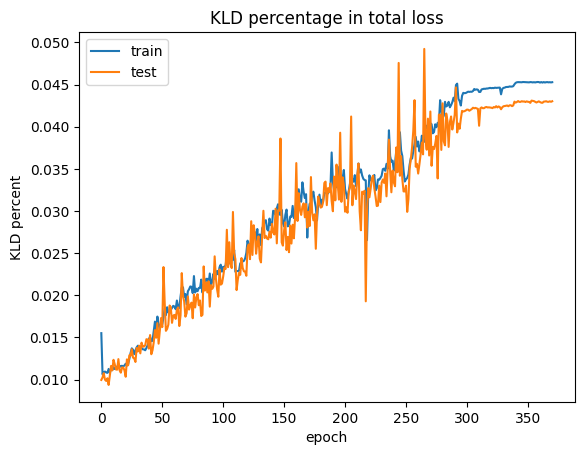

epoch 371: 100%|██████████| 266/266 [00:26<00:00, 10.22it/s]


[train] loss: 8449.626, BCE: 8066.840, KLD: 382.786, KLD/loss: 4.530%
[valid] loss: 8605.659, BCE: 8235.599, KLD: 370.060, KLD/loss: 4.300%


epoch 372: 100%|██████████| 266/266 [00:26<00:00, 10.16it/s]


[train] loss: 8445.899, BCE: 8063.100, KLD: 382.799, KLD/loss: 4.532%
[valid] loss: 8618.351, BCE: 8248.287, KLD: 370.064, KLD/loss: 4.294%


epoch 373: 100%|██████████| 266/266 [00:26<00:00, 10.15it/s]


[train] loss: 8450.147, BCE: 8067.356, KLD: 382.791, KLD/loss: 4.530%
[valid] loss: 8633.161, BCE: 8263.111, KLD: 370.050, KLD/loss: 4.286%


epoch 374: 100%|██████████| 266/266 [00:26<00:00, 10.16it/s]


[train] loss: 8450.398, BCE: 8067.295, KLD: 383.103, KLD/loss: 4.534%
[valid] loss: 8594.431, BCE: 8223.998, KLD: 370.434, KLD/loss: 4.310%


epoch 375: 100%|██████████| 266/266 [00:26<00:00, 10.12it/s]


[train] loss: 8447.458, BCE: 8064.300, KLD: 383.158, KLD/loss: 4.536%
[valid] loss: 8601.579, BCE: 8231.139, KLD: 370.440, KLD/loss: 4.307%


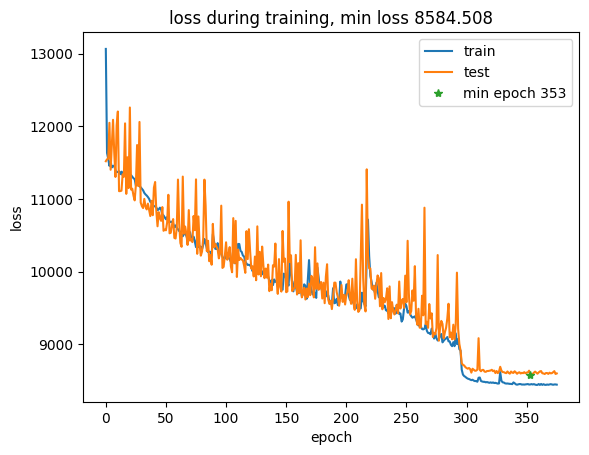

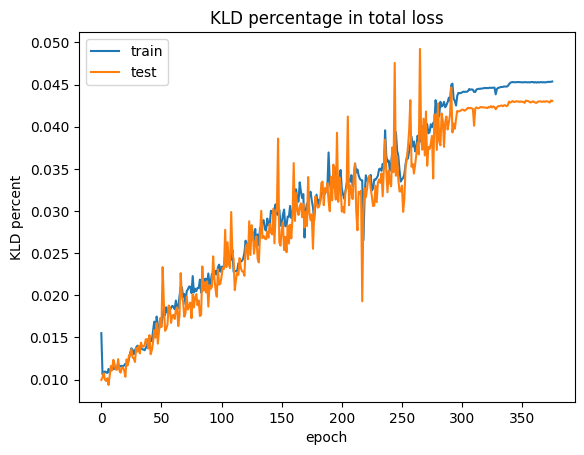

epoch 376: 100%|██████████| 266/266 [00:26<00:00, 10.18it/s]


[train] loss: 8441.887, BCE: 8058.734, KLD: 383.152, KLD/loss: 4.539%
[valid] loss: 8612.923, BCE: 8242.492, KLD: 370.432, KLD/loss: 4.301%


epoch 377: 100%|██████████| 266/266 [00:26<00:00, 10.18it/s]


[train] loss: 8445.627, BCE: 8062.478, KLD: 383.148, KLD/loss: 4.537%
[valid] loss: 8592.283, BCE: 8221.854, KLD: 370.429, KLD/loss: 4.311%


epoch 378: 100%|██████████| 266/266 [00:26<00:00, 10.19it/s]


[train] loss: 8442.281, BCE: 8059.149, KLD: 383.132, KLD/loss: 4.538%
[valid] loss: 8612.979, BCE: 8242.582, KLD: 370.398, KLD/loss: 4.300%


epoch 379: 100%|██████████| 266/266 [00:26<00:00, 10.18it/s]


[train] loss: 8443.586, BCE: 8060.477, KLD: 383.109, KLD/loss: 4.537%
[valid] loss: 8600.231, BCE: 8229.843, KLD: 370.388, KLD/loss: 4.307%


epoch 380: 100%|██████████| 266/266 [00:26<00:00, 10.20it/s]


[train] loss: 8444.133, BCE: 8061.041, KLD: 383.092, KLD/loss: 4.537%
[valid] loss: 8603.744, BCE: 8233.381, KLD: 370.363, KLD/loss: 4.305%


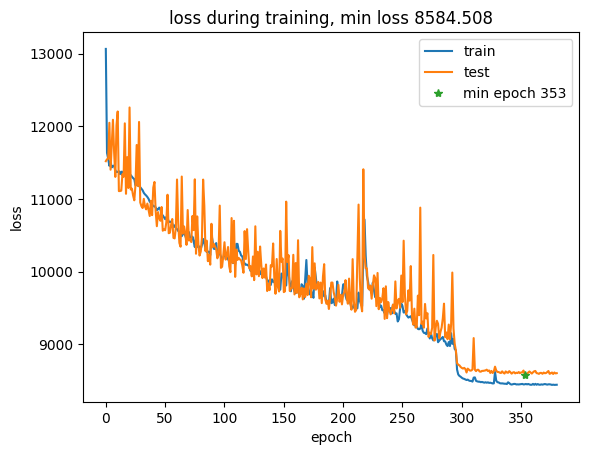

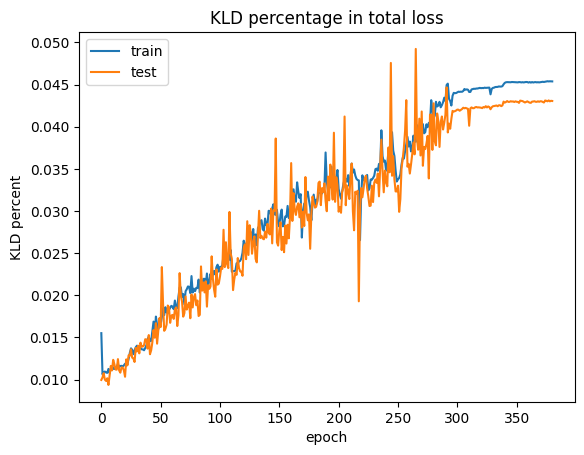

epoch 381: 100%|██████████| 266/266 [00:26<00:00, 10.17it/s]


[train] loss: 8444.954, BCE: 8061.882, KLD: 383.072, KLD/loss: 4.536%
[valid] loss: 8603.927, BCE: 8233.570, KLD: 370.357, KLD/loss: 4.305%


epoch 382: 100%|██████████| 266/266 [00:26<00:00, 10.14it/s]


[train] loss: 8458.577, BCE: 8075.558, KLD: 383.019, KLD/loss: 4.528%
[valid] loss: 8599.927, BCE: 8229.587, KLD: 370.340, KLD/loss: 4.306%


epoch 383: 100%|██████████| 266/266 [00:26<00:00, 10.12it/s]


[train] loss: 8448.823, BCE: 8065.779, KLD: 383.044, KLD/loss: 4.534%
[valid] loss: 8603.032, BCE: 8232.672, KLD: 370.359, KLD/loss: 4.305%


epoch 384: 100%|██████████| 266/266 [00:25<00:00, 10.24it/s]


[train] loss: 8445.694, BCE: 8062.637, KLD: 383.056, KLD/loss: 4.536%
[valid] loss: 8619.400, BCE: 8249.041, KLD: 370.359, KLD/loss: 4.297%
early stop, loss no decrease


In [134]:
optimizer = optim.AdamW(params=model.parameters(), lr=1e-6, weight_decay=1e-3)

start_epoch = argmin_epoch+1
if start_epoch != 0:
    model.load_state_dict(torch.load(model_saved_names[-1],
                                     map_location=device))

for epoch in range(start_epoch, start_epoch + epochs):

    train_dict[epoch], _, _, train_kld[epoch] = train(epoch)

    valid_dict[epoch], _, _, valid_kld[epoch] = test(
                            epoch, test_loader=valid_loader)

    if epoch != 0 and epoch % 5 == 0:
        plot_loss(train_dict, valid_dict)
        plot_kld(train_kld, valid_kld)

    argmin_epoch, min_loss = get_min(valid_dict)

    if epoch == argmin_epoch and epoch > 10:
        model_name = model_path+f'ckpt_{str(argmin_epoch)}.pt'
        torch.save(model.state_dict(), model_name)
        print('model save at: ',  model_name)
        model_saved_names.append(model_name)
        while len(model_saved_names) > 10:  # only reserve 10 models
            try:
                remove_model_name = model_saved_names.pop(0)
                print('remove ', remove_model_name)
                os.remove(remove_model_name)
            except:
                print(f'error when delete {model_saved_names[0]}')
    else:
        if epoch - argmin_epoch > 30:
            print('early stop, loss no decrease')
            break
        if valid_dict[epoch] / min_loss > 1.5:
            print(f'early stop, loss increase')
            break

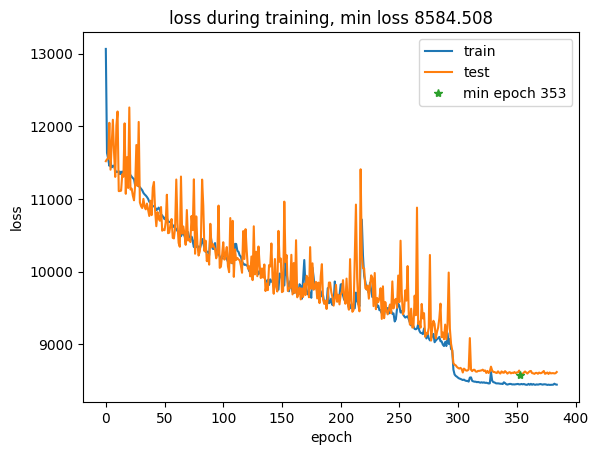

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [135]:
import pickle
from google.colab import files

# plot_loss(train_dict, valid_dict)
#         plot_kld(train_kld, valid_kld)
dict_all = {'train_loss': train_dict,
            'valid_loss': valid_dict,
            'model_in_dim': in_dim,
            'model_name': model_name}

with open('train_info.pkl', 'wb') as f:
    pickle.dump(dict_all, f)

plot_loss(dict_all['train_loss'], dict_all['valid_loss'])

files.download('train_info.pkl')
files.download(model_name)